# Librerias

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Importacion datos

Nos hemos importado la tabla resultante de la **consulta vision_cliente.sql**,que nos da una informaciós más detallada sobre cada cliente.En ella tenemos dos tipos de datos
- **Idenficativos de cada cliente**(Edad,Género,Status..) 
- **Métricas calcualadas para el análisis**(Número de compras,Coste medio Cliente,PVP..)

In [19]:
df = pd.read_csv("../data/vision_cliente.csv")
df.head()

,Customer_ID,Edad,RENTA_MEDIA_ESTIMADA,GENERO,Fecha_nacimiento,STATUS_SOCIAL,CODIGO_POSTAL,provincia,poblacion,lat,...,Dias_Medio_En_Taller,Total_Quejas,Compra_Tienda_Unica,Contrato_Seguro_Bateria,Coste_Medio_Cliente,Margen_Bruto_Medio,Margen_eur_Medio,Rentabilidad_Relativa,Churn_Cliente,Dias_Medios_Desde_Ultima_Revision
0,1,47,25641,M,11/01/1977,H,CP8470,Barcelona,Campins,2.463162,...,0.0,0,1,0,3265.320068,6131.069824,2865.750000,0.877632,0,0
1,7,36,0,F,09/01/1988,NaN,CP47009,Valladolid,Valladolid,-4.723349,...,0.0,0,1,0,2329.600098,4254.600098,1925.000000,0.826322,1,0
2,10,39,0,M,09/01/1985,NaN,CP3130,Alicante/Alacant,Santa Pola,-0.555281,...,0.0,0,1,0,1890.599976,13041.900391,11151.299805,5.898286,1,0
3,11,53,0,M,13/01/1971,NaN,CP8711,Barcelona,Òdena,1.638468,...,0.0,0,1,0,1890.599976,13041.900391,11151.299805,5.898286,1,0
4,12,47,27287,M,11/01/1977,G,CP17006,Girona,Girona,2.824119,...,0.0,0,1,0,1859.479980,3543.679932,1684.199951,0.905737,1,960


# PCA

El objetivo de este análisis es aplicar técnicas de reducción de dimensionalidad mediante **PCA** para simplificar la representación de clientes y posteriomente dividirlos en clusters,mediante **K-Means**

## Elección variables PCA

De todas la columnas que teníamos en la tabla vision_cliente, nos hemos quedado unicamente con una serie de variables numéricas para realizar el PCA.

En el archivo `apoyo.md`, esta más detallado el por qué de esta selección.

In [20]:
columnas_pca = [
    'Edad', 'RENTA_MEDIA_ESTIMADA', 'Numero_Veces_Lead', 'Total_Compras',
    'PVP_Total', 'Dias_Desde_Ultima_Compra', 'Edad_Media_Coche',
    'Total_Revisiones', 'Coste_Medio_Cliente',
    'Margen_Bruto_Medio', 'Dias_Medios_Desde_Ultima_Revision','Km_Medio_por_Revision'
]

# Creamos un nuevo DataFrame solo con las columnas seleccionadas
df_pca = df[columnas_pca].copy()
df_pca.head()

,Edad,RENTA_MEDIA_ESTIMADA,Numero_Veces_Lead,Total_Compras,PVP_Total,Dias_Desde_Ultima_Compra,Edad_Media_Coche,Total_Revisiones,Coste_Medio_Cliente,Margen_Bruto_Medio,Dias_Medios_Desde_Ultima_Revision,Km_Medio_por_Revision
0,47,25641,1,1,18579,363,0.0,0,3265.320068,6131.069824,0,0
1,36,0,1,1,15195,1621,4.0,0,2329.600098,4254.600098,0,0
2,39,0,0,1,30330,628,1.0,0,1890.599976,13041.900391,0,0
3,53,0,1,1,30330,668,1.0,0,1890.599976,13041.900391,0,0
4,47,27287,0,1,12656,1772,4.0,2,1859.479980,3543.679932,960,28456


## Escalado Variables

El escalado de las variables es fundamental antes de realizar un PCA  porque las variables que tienen una magnitud mucho mayor (por ejemplo, `PVP_Total`) pueden dominar el análisis, haciendo que el PCA refleje sobre todo esa variable y no capte bien la información de otras variables con menor rango (como `Edad` o `Total_Compras`).

Para evitarlo, utilizamos StandardScaler, que transforma las variables para que:

- Tengan media 0.
- Tengan desviación estándar 1.

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)


df_scaled = pd.DataFrame(X_scaled, columns=df_pca.columns)
df_scaled.head()

,Edad,RENTA_MEDIA_ESTIMADA,Numero_Veces_Lead,Total_Compras,PVP_Total,Dias_Desde_Ultima_Compra,Edad_Media_Coche,Total_Revisiones,Coste_Medio_Cliente,Margen_Bruto_Medio,Dias_Medios_Desde_Ultima_Revision,Km_Medio_por_Revision
0,0.387439,0.299842,0.422945,-0.541418,-0.811663,-0.771712,-1.291804,-0.865153,-0.453547,-0.659981,-0.584017,-1.035835
1,-0.637255,-1.745155,0.422945,-0.541418,-1.031924,1.255661,1.195520,-0.865153,-0.822236,-1.285083,-0.584017,-1.035835
2,-0.357793,-1.745155,-1.107027,-0.541418,-0.046802,-0.344643,-0.669973,-0.865153,-0.995210,1.642202,-0.584017,-1.035835
3,0.946364,-1.745155,0.422945,-0.541418,-0.046802,-0.280179,-0.669973,-0.865153,-0.995210,1.642202,-0.584017,-1.035835
4,0.387439,0.431118,-1.107027,-0.541418,-1.197185,1.499010,1.195520,0.473634,-1.007472,-1.521910,3.544321,0.544237


## PCA

En la curva representada a continuación, se muestra la cantidad de varianza explicada en función del número de componentes principales seleccionados. Idealmente, elegiríamos **ocho componentes**, ya que es el punto a partir del cual se explica una proporción considerable de la varianza total.

Sin embargo, como el objetivo de este análisis es **la visualización de los clientes en dos dimensiones**, seleccionamos únicamente **dos componentes principales**. Aunque explican una menor proporción de la varianza, permiten proyectar los datos en un espacio 2D más interpretable.

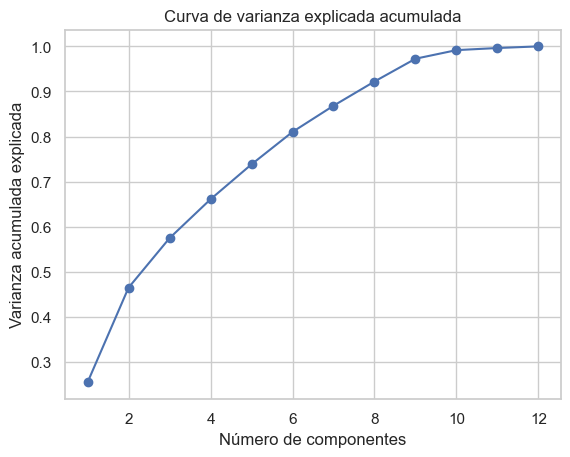

In [22]:
pca_full = PCA()
pca_full.fit(X_scaled)

plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         pca_full.explained_variance_ratio_.cumsum(), marker='o')

plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada explicada')
plt.title('Curva de varianza explicada acumulada')
plt.show()

**PCA 2 Componentes**

Se seleccionan los **dos primeros autovectores** (componentes principales) de la matriz de covarianza de los datos escalados, que mayor proporción de varinaza explican.

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca_result = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca_result.head()

,PC1,PC2
0,-2.038177,-0.693331
1,0.220000,-1.571852
2,-1.736063,-0.933732
3,-1.992450,-0.285585
4,3.004731,-2.036562


**Varianza explicada**

La proporción de varianza explicada por cada componente se obtiene normalizando los autovalores, asociados a las anteriores componentes

In [10]:
pca.explained_variance_ratio_

array([0.25469952, 0.21009586])

- Los dos primeros componentes principales explican un **46,48%** de la varianza total (**25,47%** y **21,01%** respectivamente).

- Aunque todavía no capturan toda la varianza, estos dos componentes son suficientes para realizar una visualización bidimensional útil.

**Gráfico PCA**

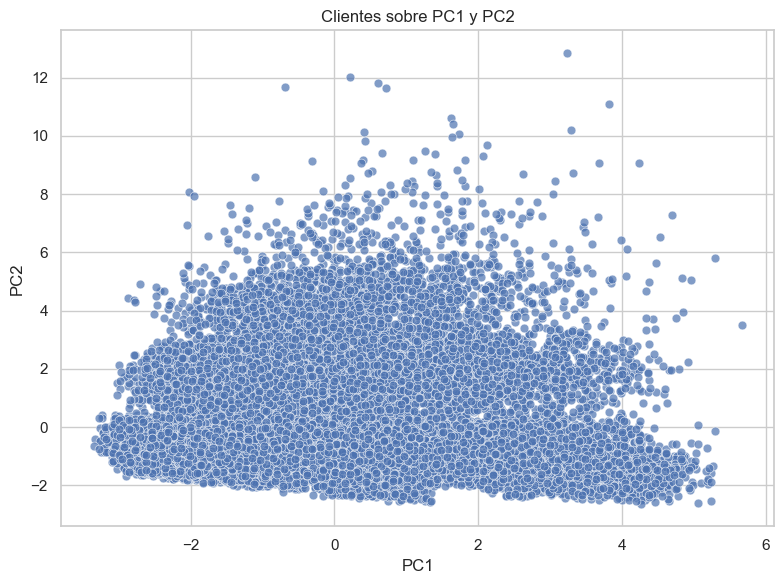

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca_result, s=40, alpha=0.7)

# Etiquetas
plt.title('Clientes sobre PC1 y PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# K-Means

## Número de Clusters

**Método Inercia**:
La inercia se define como la suma de las distancias al cuadrado de cada punto al centroide de su cluster. Un valor de inercia más bajo indica que los puntos están más cerca de su centroide, lo que sugiere que los clusters están bien definidos.

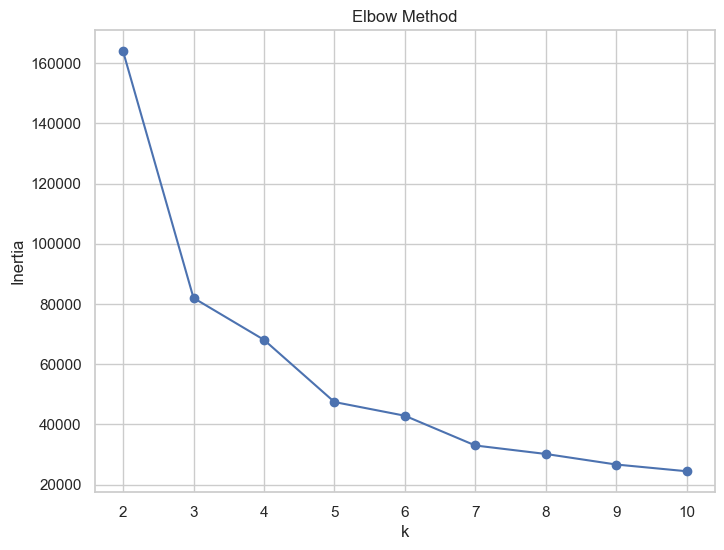

In [9]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')  # Línea con marcador en cada punto
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

**Método de la silueta**


Mide qué tan bien está agrupado cada punto en su propio cluster respecto a los demás clusters. Se calcula para cada punto \(i\) mediante la siguiente fórmula:

$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$

Donde:

- $a(i)$: Distancia media del punto $i$ respecto a los otros puntos del mismo cluster.
- $b(i)$: Distancia media del punto $i$ a los puntos del cluster más cercano al suyo.

**Interpretación:**

- Valores cercanos a **1** indican que el punto está bien agrupado en su cluster.
- Valores cercanos a **0** indican que el punto está en la frontera entre dos clusters.
- Valores negativos sugieren que el punto podría estar asignado en un cluster incorrecto.



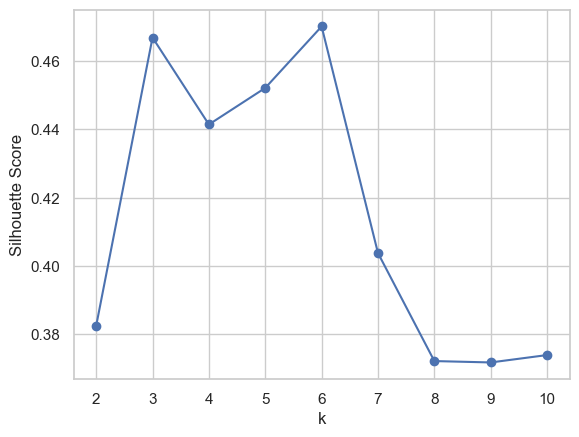

In [83]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    score = silhouette_score(X_pca, kmeans.labels_)
    sil_scores.append(score)

# Graficar el método de la silueta
plt.plot(range(2, 11), sil_scores,marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()



Tras evaluar ambos métodos, observamos lo siguiente:

- El **método del codo (inercia)** sugiere entre **3 y 4 clusters**, ya que a partir de estos puntos la reducción de inercia es menor.
- Sin embargo, el **método de la silueta** indica claramente que **3 y 6 clusters** generan una mejor separación entre grupos (mayor Silhouette Score).

Pese a que 6 clusters tiene ligeramente mejor puntuación según el método  Silhouette Score , usaremos **3 clusters** debido a su mayor simplicidad visual e interpretabilidad para la toma de decisiones prácticas en negocio.

## Representación Clusters

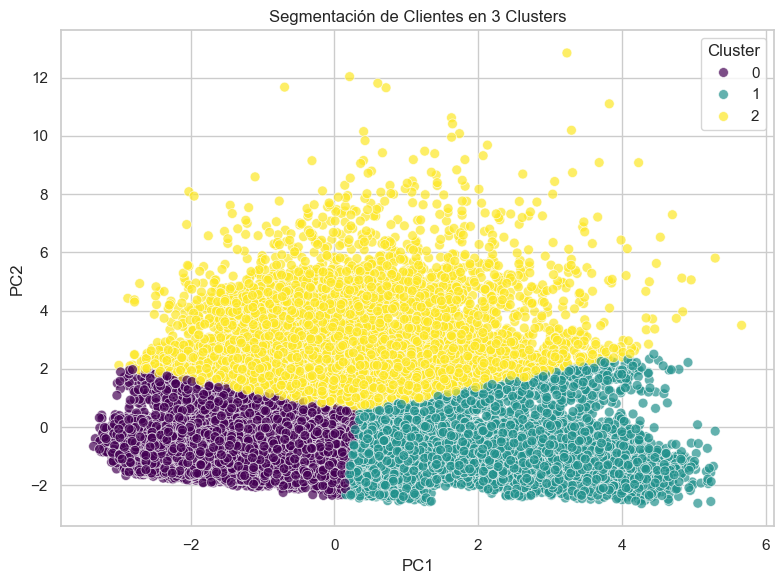

In [27]:

kmeans = KMeans(n_clusters=3, random_state=42)
df_pca_result['Cluster'] = kmeans.fit_predict(X_pca)


plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    data=df_pca_result, 
    palette='viridis', 
    s=50, 
    alpha=0.7
)

plt.title('Segmentación de Clientes en 3 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Indentificación Clientes por Cluster

In [ ]:
df['Cluster'] = df_pca_result['Cluster']

# Calculamos la media global
media_global = df[columnas_pca].mean()

# Calculamos la media por cluster
media_cluster = df.groupby('Cluster')[columnas_pca].mean()

# Creamos DataFrames individuales para cada cluster con el cociente respecto a la media global
df_cluster_0 = (media_cluster.loc[0] / media_global).to_frame(name='Cluster_0')
df_cluster_1 = (media_cluster.loc[1] / media_global).to_frame(name='Cluster_1')
df_cluster_2 = (media_cluster.loc[2] / media_global).to_frame(name='Cluster_2')


In [37]:

df_completo = pd.concat([df, df_pca_result[['PC1', 'PC2']]], axis=1)
df_completo['Cluster'] = df_pca_result['Cluster']

df_completo.to_csv("clientes_datos_cluster.csv", index=False)

**Métricas Cluster**

In [30]:
df_cluster_0

,Cluster_0
Edad,1.076030
RENTA_MEDIA_ESTIMADA,0.927025
Numero_Veces_Lead,0.763489
Total_Compras,0.808909
PVP_Total,0.802608
Dias_Desde_Ultima_Compra,0.615899
Edad_Media_Coche,0.469467
Total_Revisiones,0.253486
Coste_Medio_Cliente,0.959940
Margen_Bruto_Medio,1.024744


In [31]:
df_cluster_1

,Cluster_1
Edad,0.890697
RENTA_MEDIA_ESTIMADA,1.085713
Numero_Veces_Lead,0.762137
Total_Compras,0.799652
PVP_Total,0.782538
Dias_Desde_Ultima_Compra,1.808038
Edad_Media_Coche,1.765756
Total_Revisiones,1.536877
Coste_Medio_Cliente,1.038836
Margen_Bruto_Medio,0.947929


In [89]:
df_cluster_2

,Cluster_2
Edad,0.999913
RENTA_MEDIA_ESTIMADA,1.028885
Numero_Veces_Lead,1.867243
Total_Compras,1.712947
PVP_Total,1.752218
Dias_Desde_Ultima_Compra,0.749772
Edad_Media_Coche,0.996043
Total_Revisiones,1.805503
Coste_Medio_Cliente,1.028184
Margen_Bruto_Medio,1.024723


In [ ]:
df_clusters_comparacion = pd.concat([df_cluster_0, df_cluster_1, df_cluster_2], axis=1)
df_clusters_comparacion.to_csv("clusters_comparacion.csv", index=True)